# Example: mesh a delineated watershed

Here we mesh the [Coweeta Hydrologic Laboratory](https://www.srs.fs.usda.gov/coweeta/) as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

This might be the worst example to use to learn how to use Watershed Workflows.  But it is useful to demonstrate the breadth of problems this project was intended to solve.

This includes a range of datasets:

* NHD Plus for river network
* NRCS soils data for soil types
* NLCD for land cover/transpiration/rooting depths
* NED for elevation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
# %matplotlib notebook

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [3]:
import sys
sys.path.append("./")
# sys.path.append("/Users/shua784/Dropbox/github/watershed-workflow")
# sys.path.append("/Users/shua784/Dropbox/github/watershed-workflow/workflow_tpls")
# sys.path.append("/Users/shua784/Dropbox/github/watershed-workflow/workflow")
sys.path.append("/Users/shua784/Dropbox/github/seacas/install/lib")

sys.path.append("../../watershed-workflow")
sys.path.append("../workflow_tpls")
sys.path.append("../workflow")

In [4]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import shapely
import logging

import workflow
import workflow.source_list
import workflow.ui
import workflow.colors
import workflow.condition
import workflow.mesh
import workflow.split_hucs

workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [5]:
# specify the input shapefile and a hint as to what HUC it is in.
coweeta_shapefile = '../data/hydrologic_units/Coweeta/coweeta_basin.shp'
hint = '0601'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape
simplify = 30 # length scale to target average edge

logging.info("")
logging.info("Meshing shape: {}".format(coweeta_shapefile))
logging.info("="*30)

# get the shape and crs of the shape
crs, coweeta = workflow.get_split_form_shapes(coweeta_shapefile)

2020-12-04 11:39:32,233 - root - INFO: 
2020-12-04 11:39:32,234 - root - INFO: Meshing shape: ../data/hydrologic_units/Coweeta/coweeta_basin.shp
2020-12-04 11:39:32,234 - root - INFO: ==============================
2020-12-04 11:39:32,235 - root - INFO: 
2020-12-04 11:39:32,235 - root - INFO: Preprocessing Shapes
2020-12-04 11:39:32,236 - root - INFO: ------------------------------
2020-12-04 11:39:32,236 - root - INFO: loading file: "../data/hydrologic_units/Coweeta/coweeta_basin.shp"
/opt/anaconda3/envs/watershed_workflow/lib/python3.8/site-packages/fiona/collection.py:352: FionaDeprecationWarning: Collection slicing is deprecated and will be disabled in a future version.
  return self.session.__getitem__(item)


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [6]:
# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
workflow.source_list.log_sources(sources)

2020-12-04 11:39:33,719 - root - INFO: Using sources:
2020-12-04 11:39:33,719 - root - INFO: --------------
2020-12-04 11:39:33,720 - root - INFO: HUC: National Watershed Boundary Dataset (WBD)
2020-12-04 11:39:33,720 - root - INFO: hydrography: National Hydrography Dataset (NHD)
2020-12-04 11:39:33,721 - root - INFO: DEM: National Elevation Dataset (NED); resolution: 1 arc-second
2020-12-04 11:39:33,721 - root - INFO: soil type: National Resources Conservation Service Soil Survey (NRCS Soils)
2020-12-04 11:39:33,722 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2020-12-04 11:39:33,722 - root - INFO: soil thickness: None
2020-12-04 11:39:33,722 - root - INFO: meteorology: DayMet 1km


## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

In [ ]:
# # find what HUC our shape is in
# huc = workflow.find_huc(sources['HUC'], coweeta.exterior(), crs, hint, shrink_factor=0.1)
# logging.info("Found Coweeta in HUC: {}".format(huc))

In [7]:
huc = "060102020103"

In [8]:
rivers = True
if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = workflow.get_reaches(sources['hydrography'], huc, 
                                      coweeta.exterior().bounds, crs, cvrt = True)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers = workflow.simplify_and_prune(coweeta, reaches, filter=True, simplify=simplify, cut_intersections=True)

else:
    rivers = list()
    workflow.split_hucs.simplify(coweeta, simplify)



2020-12-04 11:39:36,269 - root - INFO: 
2020-12-04 11:39:36,269 - root - INFO: Preprocessing Hydrography
2020-12-04 11:39:36,270 - root - INFO: ------------------------------
2020-12-04 11:39:36,270 - root - INFO: Loading streams in HUC 060102020103
2020-12-04 11:39:36,271 - root - INFO:          and/or bounds (273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)
2020-12-04 11:39:36,272 - root - INFO: Using Hydrography file "/Users/shua784/OneDrive - PNNL/github/watershed-workflow/examples/data/hydrography/NHD_H_06010202_GDB/NHD_H_06010202.gdb"
2020-12-04 11:39:36,654 - root - INFO:   found 35 reaches
2020-12-04 11:39:36,655 - root - INFO: convert to destination crs : EPSG:26917
2020-12-04 11:39:40,250 - root - INFO: out crs: EPSG:26917
2020-12-04 11:39:40,250 - root - INFO: convert to 35 shapely files
2020-12-04 11:39:40,254 - root - INFO: merge all shapely branched lines into a single line
2020-12-04 11:39:40,257 - root - INFO: 
2020-12-04 11:39:40,257 - root

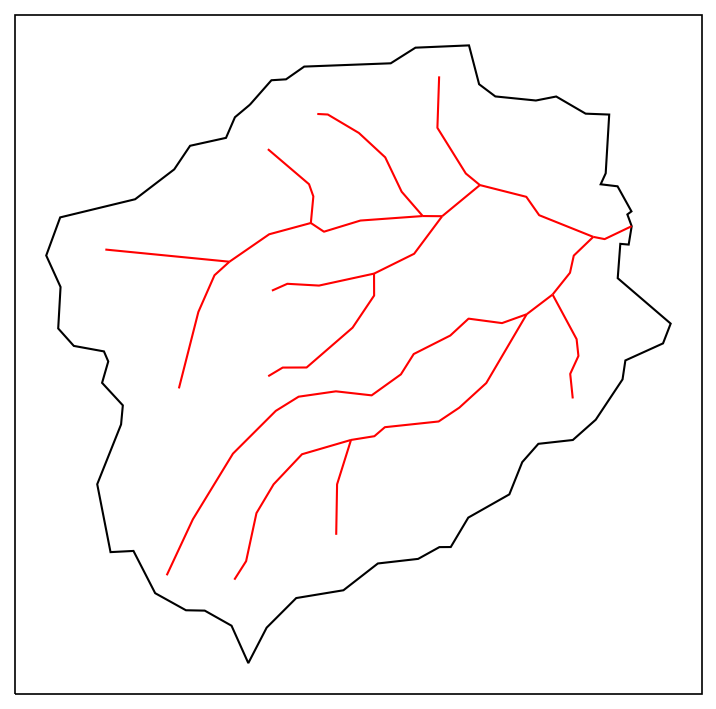

In [9]:
# plot what we have so far -- an image of the HUC and its stream network
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

workflow.plot.hucs(coweeta, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)

plt.show()

2020-12-04 11:40:01,961 - root - INFO: 
2020-12-04 11:40:01,962 - root - INFO: Meshing
2020-12-04 11:40:01,962 - root - INFO: ------------------------------
2020-12-04 11:40:01,963 - root - INFO: Triangulating...
2020-12-04 11:40:01,965 - root - INFO:    132 points and 132 facets
2020-12-04 11:40:01,965 - root - INFO:  checking graph consistency
2020-12-04 11:40:01,966 - root - INFO:  tolerance is set to 1
2020-12-04 11:40:01,967 - root - INFO:  building graph data structures
2020-12-04 11:40:01,968 - root - INFO:  triangle.build...
2020-12-04 11:40:01,968 - root - WARNING: Triangulate: '--enforce-delaunay' option requires a hacked `meshpy.triangle`.  Proceeding without this option because it is not recognized.
2020-12-04 11:40:09,766 - root - INFO:   ...built: 8171 mesh points and 16119 triangles
2020-12-04 11:40:09,766 - root - INFO: Plotting triangulation diagnostics
2020-12-04 11:40:10,979 - root - INFO:   min area = 209.30328369140625
2020-12-04 11:40:10,981 - root - INFO:   max a

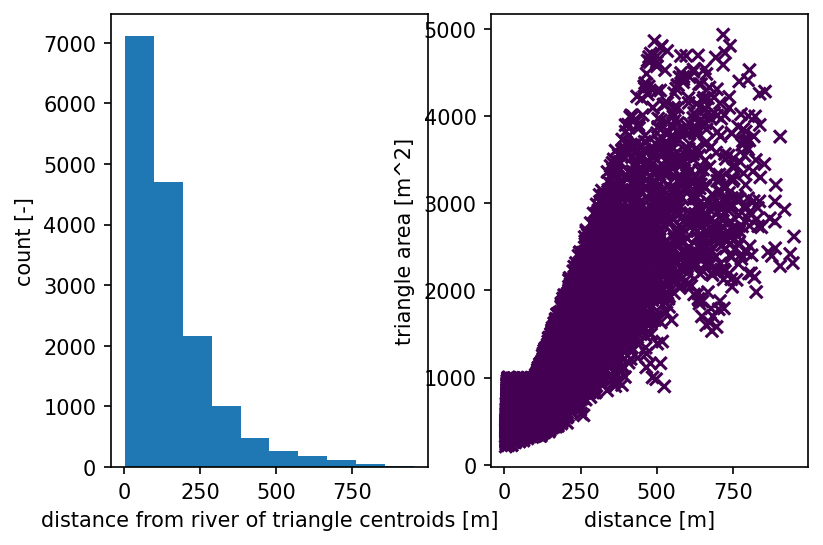

In [10]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.
d0 = 100; d1 = 500
A0 = 1000; A1 = 5000
#A0 = 500; A1 = 2500
#A0 = 100; A1 = 500

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, d = workflow.triangulate(coweeta, rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               enforce_delaunay=True,
                                               diagnostics=True)
#mesh_points2, mesh_tris, d = workflow.triangulate(coweeta, rivers,
#                                                 refine_max_area=100000,
#                                                 enforce_delaunay=True,
#                                                 diagnostics=True)

### elevate meshes to DEM

Automatically download DEM from USGS. Alternatively, load local DEM files.

In [101]:
fname_dem = "./data/dem/USGS_NED_1as_n36_w084.img"
dem_profile, dem = workflow.get_raster_on_shape(fname_dem, coweeta.exterior(), crs)

2020-12-04 17:01:33,871 - root - INFO: 
2020-12-04 17:01:33,872 - root - INFO: Preprocessing Raster
2020-12-04 17:01:33,872 - root - INFO: ------------------------------
2020-12-04 17:01:33,873 - root - INFO: collecting raster
2020-12-04 17:01:33,875 - root - INFO: loading file: "./data/dem/USGS_NED_1as_n36_w084.img"
2020-12-04 17:01:33,878 - root - INFO: src CRS: EPSG:4269
2020-12-04 17:01:33,999 - root - INFO: Got raster of shape: (240, 277)
2020-12-04 17:01:33,999 - root - INFO: Raster bounds: (-83.48845037186388, 35.08381933600275, -83.41150592741688, 35.01715266933386)


In [17]:
# get a raster for the elevation map, based on NED
dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], coweeta.exterior(), crs)

2020-12-04 11:48:46,033 - root - INFO: 
2020-12-04 11:48:46,033 - root - INFO: Preprocessing Raster
2020-12-04 11:48:46,034 - root - INFO: ------------------------------
2020-12-04 11:48:46,035 - root - INFO: collecting raster
2020-12-04 11:48:46,150 - root - INFO: Collecting DEMs to tile bounds: [-83.48845037186388, 35.01734099944037, -83.41165773504302, 35.08381933600275]
2020-12-04 11:48:46,152 - root - INFO:   Need:
2020-12-04 11:48:46,153 - root - INFO:     /Users/shua784/OneDrive - PNNL/github/watershed-workflow/examples/data/dem/USGS_NED_1as_n36_w084.img
2020-12-04 11:48:46,153 - root - INFO: source files already exist!
2020-12-04 11:48:46,176 - root - INFO: Got raster of shape: (240, 277)
2020-12-04 11:48:46,177 - root - INFO: Raster bounds: (-83.48845037186388, 35.08381933600275, -83.41150592741688, 35.01715266933386)


In [102]:
# elevate the triangle nodes to the dem
mesh_points3 = workflow.elevate(mesh_points2, crs, dem, dem_profile)

2020-12-04 17:01:55,692 - root - INFO: 
2020-12-04 17:01:55,692 - root - INFO: Elevating Triangulation to DEM
2020-12-04 17:01:55,693 - root - INFO: ------------------------------


Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

[Text(3878000.0, 0, ''),
 Text(3879000.0, 0, ''),
 Text(3880000.0, 0, ''),
 Text(3881000.0, 0, ''),
 Text(3882000.0, 0, ''),
 Text(3883000.0, 0, ''),
 Text(3884000.0, 0, ''),
 Text(3885000.0, 0, '')]

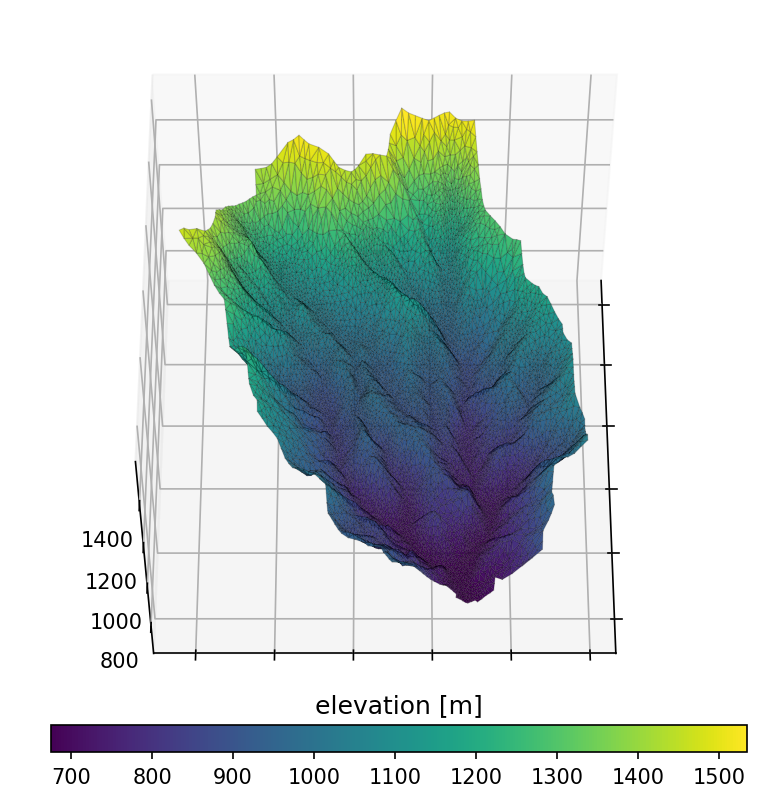

In [103]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize_3d)
ax = workflow.plot.get_ax('3d', fig, window=[0.0,0.2,1,0.8])
cax = fig.add_axes([0.23,0.18,0.58,0.03])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="horizontal", cax=cax)

t = cax.set_title('elevation [m]')
ax.view_init(55,0)
ax.set_xticklabels(list())
ax.set_yticklabels(list())

#fig.savefig('coweeta_dem_3d')

(273391.6231597871, 279720.3829351622)
(3878583.928534328, 3884209.492779106)


Text(0.5, 1.0, 'elevation [m]')

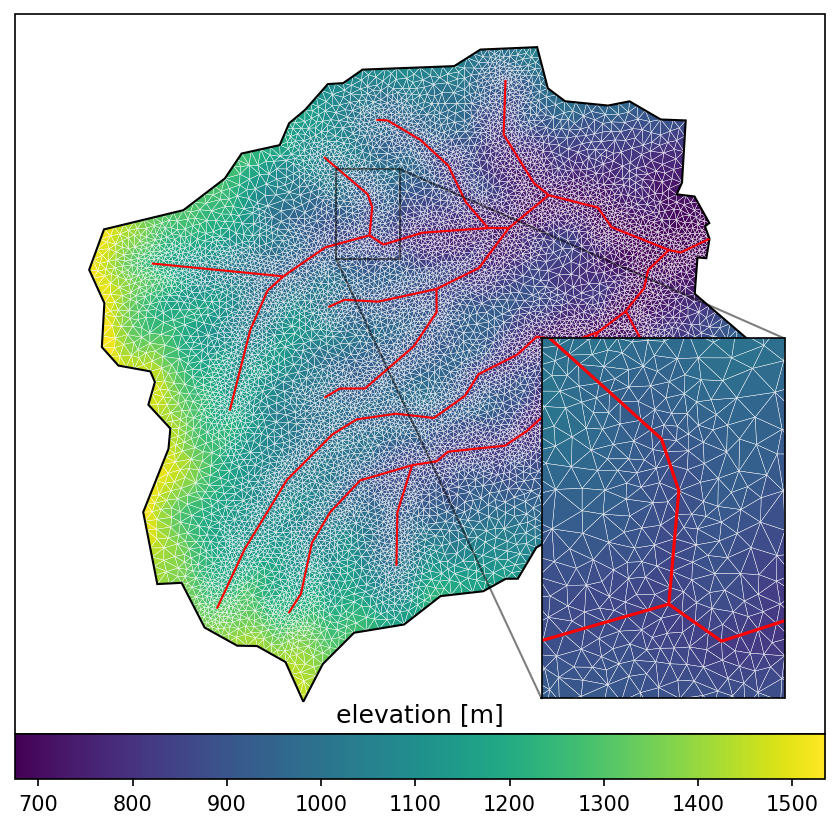

In [85]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
#ax2 = workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

xlim = (275900., 276400.)
ylim = (3882300., 3883000.)

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.2)
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
workflow.plot.hucs(coweeta, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)
ax.set_aspect('equal', 'datalim')

mp2 = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color='elevation', edgecolor='white', linewidth=0.2)
workflow.plot.hucs(coweeta, crs, ax=ax2, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax2, color='red', linewidth=1.5)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])

ax.indicate_inset_zoom(ax2, edgecolor='k')


print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('elevation [m]')
# fig.savefig('coweeta_dem2')

In [21]:
# construct the 2D mesh
m2 = workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))

max diff =  5.682766624410078


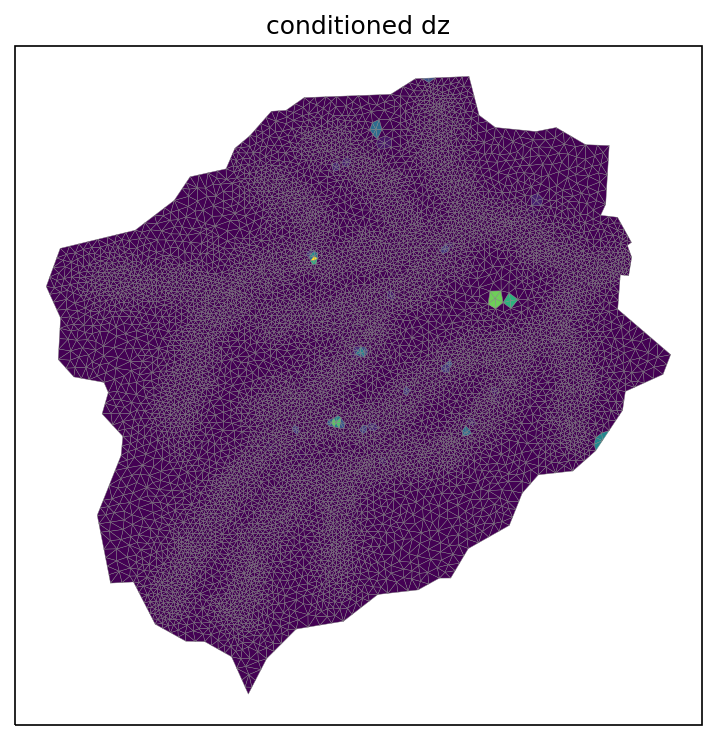

In [22]:
# hydrologically condition the mesh
workflow.condition.condition(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.points[:,2] - mesh_points3[:,2] 
print("max diff = ", np.abs(diff[:,2]).max())
fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='gray', 
                            linewidth=0.2, ax=ax)
ax.set_title('conditioned dz')
plt.show()

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

Note: it will take a while for the first time when downloading the NLCD dataset for the CONUS (~17 GB)

In [24]:
# download the NLCD raster
lc_profile, lc_raster = workflow.get_raster_on_shape(sources['land cover'], 
                                                     coweeta.exterior(), crs)

2020-12-04 14:03:01,354 - root - INFO: 
2020-12-04 14:03:01,355 - root - INFO: Preprocessing Raster
2020-12-04 14:03:01,355 - root - INFO: ------------------------------
2020-12-04 14:03:01,356 - root - INFO: collecting raster
2020-12-04 14:03:01,383 - root - INFO: CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
2020-12-04 14:03:01,504 - root - INFO: Got raster of shape: (1, 180, 173)
2020-12-04 14:03:01,504 - root - INFO: Raster bounds: (1

In [25]:
# resample the raster to the triangles
lc = workflow.values_from_raster(m2.centroids(), crs, lc_raster, lc_profile, algorithm='nearest')

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))

2020-12-04 14:03:05,317 - root - INFO: Found land cover dtypes: uint8
2020-12-04 14:03:05,319 - root - INFO: Found land cover types: {0, 41, 42, 43, 81, 52, 21, 22, 23}


Text(0.5, 1.0, 'land cover index')

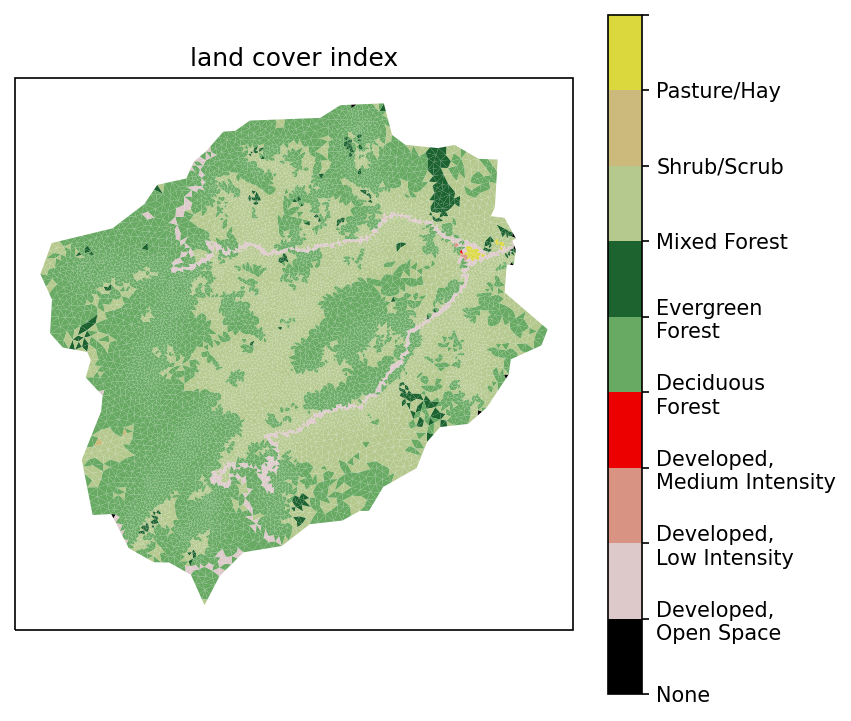

In [26]:
# plot the NLCD data

# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                workflow.colors.generate_nlcd_colormap(lc)

# this is just hacking the label names to make them display a bit neater for a cleaner plot
nlcd_labels_fw = []
for label in nlcd_labels:
    label_fw = label
    if len(label) > 15:
        if ' ' in label:
            lsplit = label.split()
            if len(lsplit) == 2:
                label_fw = '\n'.join(lsplit)
            elif len(lsplit) == 4:
                label_fw = '\n'.join([' '.join(lsplit[0:2]),
                                      ' '.join(lsplit[2:])])
            elif len(lsplit) == 3:
                if len(lsplit[0]) > len(lsplit[-1]):
                    label_fw = '\n'.join([lsplit[0],
                                          ' '.join(lsplit[1:])])
                else:
                    label_fw = '\n'.join([' '.join(lsplit[:-1]),
                                          lsplit[-1]])
    nlcd_labels_fw.append(label_fw)

# plot the image
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

polys = workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
mp = pcm.ScalarMappable(norm=nlcd_norm, cmap=nlcd_cmap)
cb = fig.colorbar(mp)
cb.set_ticks(nlcd_ticks)
cb.set_ticklabels(nlcd_labels_fw)
ax.set_title("land cover index")
# fig.savefig('coweeta_nlcd')

## Subsurface properties

Get soil structure from SSURGO

In [27]:
# download the NRCS soils data as shapes and project it onto the mesh
import workflow.sources.manager_nrcs
import matplotlib.cm

# -- download the shapes
target_bounds = coweeta.exterior().bounds
_, soil_survey = workflow.get_shapes(sources['soil type'], target_bounds, crs)

# -- log the bounds targetted and found
logging.info('target bounds: {}'.format(target_bounds))
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(soil_survey).bounds))

# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array([shp.properties['id'] for shp in soil_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_raster, soil_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, soil_survey,
                                              soil_ids, crs)

# -- resample the raster to the triangles
soil_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         soil_color_raster, soil_color_profile)

2020-12-04 14:03:48,294 - root - INFO: 
2020-12-04 14:03:48,295 - root - INFO: Preprocessing Shapes
2020-12-04 14:03:48,295 - root - INFO: ------------------------------
2020-12-04 14:03:48,427 - root - INFO:   Using filename: /Users/shua784/OneDrive - PNNL/github/watershed-workflow/examples/data/soil_survey/soil_survey_shape_-83.4790_35.0269_-83.4208_35.0743.gml
2020-12-04 14:03:48,481 - root - INFO:   Found 460 shapes.
2020-12-04 14:03:48,482 - root - INFO:   and crs: {'init': 'epsg:4326'}
2020-12-04 14:04:40,118 - root - INFO: target bounds: (273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)
2020-12-04 14:04:40,621 - root - INFO: shape union bounds: (272780.41575804196, 3877673.167325338, 281292.5042037172, 3887703.7251368817)
2020-12-04 14:04:40,622 - root - INFO: Coloring shapes onto raster:
2020-12-04 14:04:40,622 - root - INFO:   target_bounds = (273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)
2020-12-04 14:04:40,623 - ro

In [29]:
unique_soil_id = np.unique(soil_color)

logging.info(f'unique soil MUKEYs:\n {np.array(np.unique(soil_color, return_counts=True)).T}')
np.savetxt('./soil_ids.txt', np.array(np.unique(soil_color, return_counts=True)).T, 
           delimiter=' ', fmt = '%.0d')

2020-12-04 14:07:00,721 - root - INFO: unique soil MUKEYs:
 [[545800     30]
 [545801      3]
 [545803    309]
 [545805     11]
 [545806    212]
 [545807   1212]
 [545811      1]
 [545813     37]
 [545814     52]
 [545815     31]
 [545818   2282]
 [545819    813]
 [545820     80]
 [545829     58]
 [545830    424]
 [545831    606]
 [545835     24]
 [545836    802]
 [545837   3022]
 [545838    750]
 [545842     88]
 [545843   1086]
 [545853    663]
 [545854   1699]
 [545855    134]
 [545857    503]
 [545859    110]
 [545860    349]
 [545861    117]
 [545863      1]
 [545874    187]
 [545875     28]
 [545876    179]
 [545878    156]
 [545882     54]
 [545885      6]]


Text(0.5, 1.0, 'soil type index')

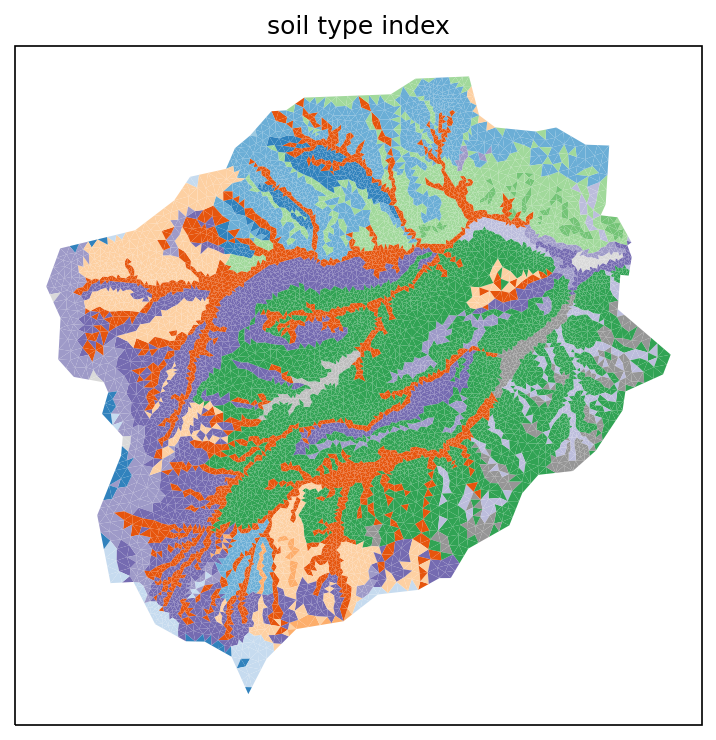

In [28]:
# plot the soil data
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=soil_color, cmap='tab20c')
ax.set_title('soil type index')

# fig.savefig('coweeta_soils')

## map geology

1. Manually download global geology map (GLHYMPS v2.0) from [here](https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/TTJNIU), ~4 GB
2. Extract the shapefile and place it under `watershed-workflow/data/geology/`

In [142]:
fname_geology = "../data/geology/GLHYMPS.shp"
fname_geology = "/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/GLHYMPS_v2/GLHYMPS.shp"

# target_bounds = coweeta.exterior().bounds
_, geology = workflow.get_shapes(fname_geology, index_or_bounds=target_bounds, crs=crs)

2020-12-07 11:17:58,223 - root - INFO: 
2020-12-07 11:17:58,224 - root - INFO: Preprocessing Shapes
2020-12-07 11:17:58,224 - root - INFO: ------------------------------
2020-12-07 11:17:58,224 - root - INFO: loading file: "/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/GLHYMPS_v2/GLHYMPS.shp"
2020-12-07 11:17:58,357 - fiona.ogrext - INFO: Failed to auto identify EPSG: 7
2020-12-07 11:18:07,718 - root - INFO: src CRS: {'proj': 'cea', 'lat_ts': 0, 'lon_0': 0, 'x_0': 0, 'y_0': 0, 'datum': 'WGS84', 'units': 'm', 'no_defs': True}


**map geology id to meshes**

In [64]:
# target_bounds = watershed.exterior().bounds
shape_union_bounds = shapely.ops.cascaded_union(geology).bounds

# -- log the bounds targetted and found
logging.info(f'target bounds: {target_bounds}')
logging.info(f'shape union bounds: {shape_union_bounds}')
if target_bounds[0] < shape_union_bounds[0] or target_bounds[1] < shape_union_bounds[1] or target_bounds[2] > shape_union_bounds[2] or target_bounds[3] > shape_union_bounds[3]:
    raise RuntimeError('target watershed falls outside the shape union bound!')

# -- determine the geology id for each polygon
geol_ids = np.array([shp.properties['OBJECTID_1'] for shp in geology], np.int32)

# convert shapefile to raster using geology ids
geol_color_raster, geol_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, target_dx=10, shapes=geology,
                                              shape_colors=geol_ids, shapes_crs = crs, nodata=-9999)

2020-12-04 15:30:11,456 - root - INFO: target bounds: (273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)
2020-12-04 15:30:11,457 - root - INFO: shape union bounds: (159518.27011641115, 3816621.6554112737, 431027.3363569959, 4024643.4346461874)
2020-12-04 15:30:11,458 - root - INFO: Coloring shapes onto raster:
2020-12-04 15:30:11,458 - root - INFO:   target_bounds = (273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)
2020-12-04 15:30:11,459 - root - INFO:   out_bounds = [273966.0, 3878839.0, 279146.0, 3883959.0]
2020-12-04 15:30:11,459 - root - INFO:   pixel_size = 10
2020-12-04 15:30:11,460 - root - INFO:   width = 518, height = 512
2020-12-04 15:30:11,460 - root - INFO:   and 1 independent colors of dtype int32


In [65]:
# -- resample the raster to the triangles
geol_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         geol_color_raster, geol_color_profile)

unique_geol_id = np.unique(geol_color)
logging.info(f'unique geology ids: {np.array(np.unique(geol_color, return_counts=True)).T}')

np.savetxt('./geology_ids.txt', np.array(np.unique(geol_color, return_counts=True)).T, 
           delimiter=' ', fmt = '%.0d')

2020-12-04 15:30:22,409 - root - INFO: unique geology ids: [[1793338   16119]]


### plot geology map

(273712.5998, 279399.40619999997, 3878583.92855, 3884209.4924500003)

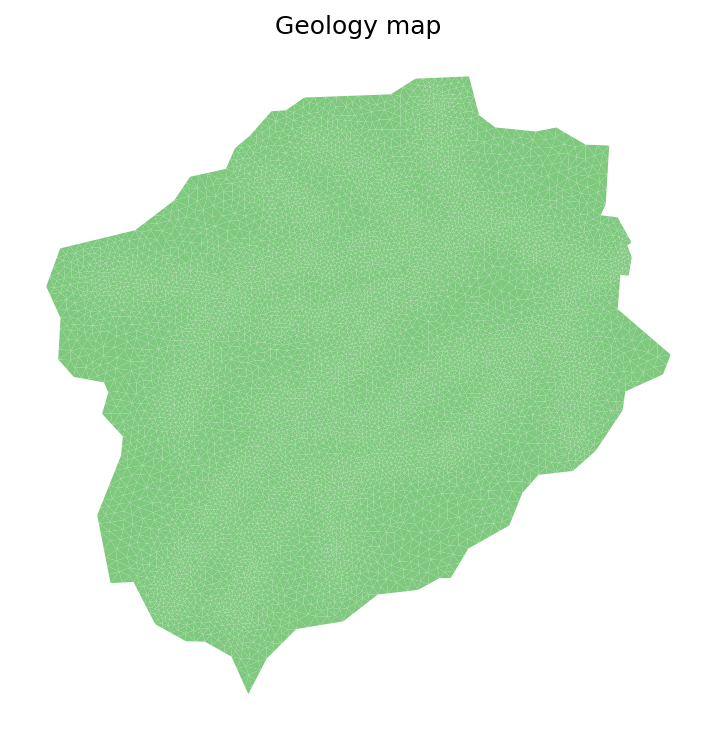

In [66]:
# plot the soil data
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=geol_color, cmap='Accent')
ax.set_title('Geology map')
ax.axis('off')
# ax.legend()

# fig.savefig(fig_geol_map, dpi = 300, transparent = True)

## get bedrock depth

1. Download global depth to bedrock at 250 m resolution from [soilgrids](http://globalchange.bnu.edu.cn/research/dtb.jsp). ~8 GB
2. unzip and extact the raster file
3. place the raster file under `watershed-workflow/data/bedrock/`

In [86]:
fname_DTB = "../data/bedrock/Global_absoluteDTB_M_250m_ll.tif"
fname_DTB = "/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/depth-to-bedrock/Global_absoluteDTB_M_250m_ll.tif"

In [123]:
DTB_profile, DTB_raster = workflow.get_raster_on_shape(fname_DTB, coweeta.exterior(), crs, nodata=-99999)

2020-12-04 17:19:15,885 - root - INFO: 
2020-12-04 17:19:15,886 - root - INFO: Preprocessing Raster
2020-12-04 17:19:15,886 - root - INFO: ------------------------------
2020-12-04 17:19:15,887 - root - INFO: collecting raster
2020-12-04 17:19:15,888 - root - INFO: loading file: "/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/depth-to-bedrock/Global_absoluteDTB_M_250m_ll.tif"
2020-12-04 17:19:16,037 - root - INFO: Got raster of shape: (32, 37)
2020-12-04 17:19:16,037 - root - INFO: Raster bounds: (-83.48845037186388, 35.08381933600275, -83.41136705086387, 35.017152680002745)


In [124]:
# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB_mesh = workflow.values_from_raster(m2.centroids(), crs, DTB_raster, DTB_profile)

In [125]:
logging.info(f'minimum depth-to-bedrock: {np.nanmin(DTB_mesh)} m')
logging.info(f'maximum depth-to-bedrock: {np.nanmax(DTB_mesh)} m')

2020-12-04 17:19:34,723 - root - INFO: minimum depth-to-bedrock: 12.72 m
2020-12-04 17:19:34,724 - root - INFO: maximum depth-to-bedrock: 19.68 m


### plot depth to bedrock

In [126]:
DTB_3d = workflow.elevate(mesh_points2, crs, DTB_raster, DTB_profile)

2020-12-04 17:19:42,297 - root - INFO: 
2020-12-04 17:19:42,298 - root - INFO: Elevating Triangulation to DEM
2020-12-04 17:19:42,298 - root - INFO: ------------------------------


(273712.5998, 279399.40619999997)
(3878583.92855, 3884209.4924500003)


Text(0.5, 1.0, 'DTB [m]')

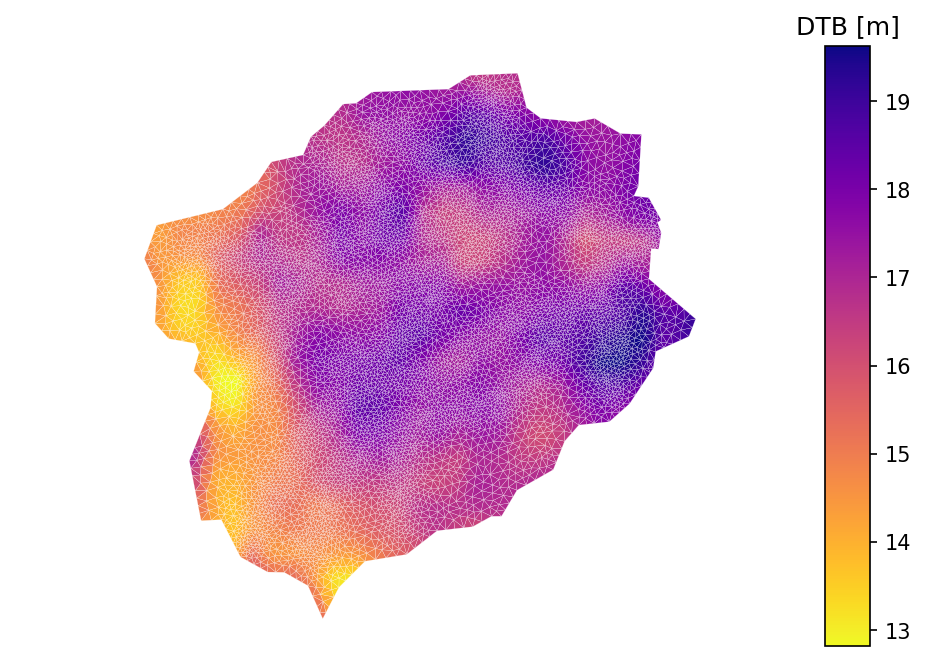

In [127]:
# plot the resulting surface mesh
fig = plt.figure(figsize=(6,5))
ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

mp = workflow.plot.triangulation(DTB_3d, mesh_tris, crs, ax=ax, 
                                 color='elevation', cmap = 'plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
# workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
# workflow.plot.rivers(rivers, crs, ax=ax, color='aqua', linewidth=1)
ax.set_aspect('equal', 'datalim')


# ax.margins(0.5)
ax.axis('off')
# add scalebar, use 1 for UTM coordinates, the default unit is "m"
# scalebar1 = ScaleBar(1, location = "lower left")
# ax.add_artist(scalebar1)
# scalebar2 = ScaleBar(1, location = "upper right")

# ax2.add_artist(scalebar2)

print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('DTB [m]')

## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

The logic of assigning material ids is: 

- assume top 2 m is soil. No verical heterogeneity (i.e., each soil layer has the same property)
- use depth-to-bedrock to form the model bottom and assume everything below DTB is bedrock
- assume anything in between soil and bedrock is geologic units. No vertical heterogeneity

In [129]:
# set the model bottom so it is equal to the largest depth of DTB
total_tckness = np.ceil(DTB_mesh.max())
logging.info(f'total thickness: {total_tckness} m')

2020-12-04 17:24:53,192 - root - INFO: total thickness: 20.0 m


In [130]:
ele_per_layer = mesh_tris.shape[0]

In [133]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []
z_top = []

z = 0.0
z_top.append(z)
# -- soil layer --
#  top 6 m
#  5 cm initial top cell
#  10 cells
#  expanding dz, growing with depth
ncells = 6
dz = 0.05
layer_dz = 2 # total top thickness

tele = workflow.mesh.telescope_factor(ncells, dz, layer_dz)
logging.info("Got telescoping factor: {}".format(tele))
for i in range(ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(soil_color)
    z += dz
#     dz *= tele
    dz = round(dz * tele, 2)
    z_top.append(z)    

# -- geologic layer --
# keep going for 2m cells until we hit the bottom of
# the domain
dz = 2.0

geo_ncells = int(np.ceil((total_tckness-z)/dz))
for i in range(geo_ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
#     ilayer_id = 900 + ncells + i + 1
#     layer_mat_ids.append(ilayer_id * np.ones_like(soil_color))
    layer_mat_ids.append(geol_color)
    z += dz    
    z_top.append(z)

2020-12-04 17:27:26,014 - root - INFO: Converged?: ratio = 1.7857749000436356, layer z (target = 2) = -5.985434370359144e-12
2020-12-04 17:27:26,014 - root - INFO: Got telescoping factor: 1.7857749000436356


In [134]:
# print the summary
workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2020-12-04 17:27:27,438 - root - INFO: Cell summary:
2020-12-04 17:27:27,439 - root - INFO: ------------------------------------------------------------
2020-12-04 17:27:27,439 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2020-12-04 17:27:27,440 - root - INFO: ------------------------------------------------------------
2020-12-04 17:27:27,440 - root - INFO:  00 	| 00 	| 545819 	|   0.050000 	|   0.000000
2020-12-04 17:27:27,441 - root - INFO:  01 	| 01 	| 545819 	|   0.090000 	|   0.050000
2020-12-04 17:27:27,441 - root - INFO:  02 	| 02 	| 545819 	|   0.160000 	|   0.140000
2020-12-04 17:27:27,441 - root - INFO:  03 	| 03 	| 545819 	|   0.290000 	|   0.300000
2020-12-04 17:27:27,442 - root - INFO:  04 	| 04 	| 545819 	|   0.520000 	|   0.590000
2020-12-04 17:27:27,442 - root - INFO:  05 	| 05 	| 545819 	|   0.930000 	|   1.110000
2020-12-04 17:27:27,443 - root - INFO:  06 	| 06 	| 1793338 	|   2.000000 	|   2.040000
2020-12-04 17:27:27,443 - root - INFO:  07 	| 07 	| 1793338 	|  

### add bedrock material

In [132]:
def doArraysIntersect(array1, array2):
    return bool(set(array1) & set(array2))

if doArraysIntersect(unique_geol_id, unique_soil_id) or doArraysIntersect(unique_geol_id, [999]) or doArraysIntersect(unique_soil_id, [999]):
    raise RuntimeWarning('Common id is found in either soil/geol/bedrock!')

In [135]:
# get depth below top cell face
z_top = np.asarray(z_top)
z_center = z_top[:-1] + (z_top[1:]-z_top[:-1])/2

In [136]:
mat_ids = np.stack(layer_mat_ids)

for icol in np.arange(mat_ids.shape[1])[:]:

    idtb = DTB_mesh[icol]
    # assume anything below DTB is bedrock
    idx = z_center > idtb
    
    # assign id=999 to bedrock
    mat_ids[idx, icol] = 999

In [137]:
layer_mat_ids = [mat_ids[row, :] for row in np.arange(mat_ids.shape[0])]

### extrusion

In [138]:
# extrude
m3 = workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

### add sidesets from land cover type

In [139]:
# add back on land cover side sets
surf_ss = m3.side_sets[1]

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(lc == index)[0]
    ss = workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.elem_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

In [140]:
# save to disk
try:
    os.remove('./meshes/coweeta_basin.exo')
except FileNotFoundError:
    pass
m3.write_exodus('./meshes/coweeta_basin.exo')


You are using exodus.py v 1.19.1 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: ./meshes/coweeta_basin.exo
Closing exodus file: ./meshes/coweeta_basin.exo
